In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#folder_path = '/content/drive/MyDrive/New folder/processed_data_for_cnn'

###Translation_Gaussian_noise_Shearing_Scaling together

All videos are augmented

All four augmentation techniques -
1. Translation,

2. Gaussian noise addition,

3. Shearing, and

4. Scaling

 are applied together to each video.

Horizontal Translation: Each video is randomly translated horizontally
by a factor between -20% and +20%.

Gaussian Noise: Gaussian noise with a mean of zero and a randomly applied standard deviation (ranging from 5 to 25) is added to each video.

Horizontal Shearing: Each video undergoes random horizontal shearing, with a factor chosen between -0.2 and +0.2.




Scaling: Each video is scaled by a factor between 60% and 120%, while maintaining its original dimensions.





###Generating 3 copies of augmented videos and saving it with the original data(train)

In [ ]:
import cv2
import os
import numpy as np
import random
from tqdm import tqdm


def augment_frame(frame, frame_width, frame_height, translation_percent, shear_factor, noise_stddev, scale_factor):
    """
    Apply translation, shearing, scaling, and Gaussian noise to a frame.
    """
    # Translation
    translation_pixels = int(frame_width * translation_percent)
    translation_matrix = np.float32([[1, 0, translation_pixels], [0, 1, 0]])
    translated_frame = cv2.warpAffine(frame, translation_matrix, (frame_width, frame_height))

    # Shearing
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    sheared_frame = cv2.warpAffine(translated_frame, shear_matrix, (frame_width, frame_height))

    # Scaling
    center_x, center_y = frame_width // 2, frame_height // 2
    scaled_width = int(frame_width * scale_factor)
    scaled_height = int(frame_height * scale_factor)

    scaled_frame = cv2.resize(sheared_frame, (scaled_width, scaled_height))

    # Crop or pad to maintain original size
    if scale_factor > 1.0:
        start_x = (scaled_width - frame_width) // 2
        start_y = (scaled_height - frame_height) // 2
        scaled_frame = scaled_frame[start_y:start_y + frame_height, start_x:start_x + frame_width]
    else:
        pad_x = (frame_width - scaled_width) // 2
        pad_y = (frame_height - scaled_height) // 2
        scaled_frame = cv2.copyMakeBorder(
            scaled_frame,
            pad_y, frame_height - scaled_height - pad_y,
            pad_x, frame_width - scaled_width - pad_x,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )

    # Add Gaussian noise
    noise = np.random.normal(0, noise_stddev, frame.shape).astype(np.float32)
    noisy_frame = np.clip(scaled_frame + noise, 0, 255).astype(np.uint8)

    return noisy_frame


def process_video(video_path, main_folder, output_folder, num_copies=3, **augmentation_params):
    """
    Process a single video and save augmented copies.
    """
    # Recreate directory structure
    relative_path = os.path.relpath(video_path, main_folder)
    output_dir = os.path.join(output_folder, os.path.dirname(relative_path))
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    # Save the original video
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    original_output_path = os.path.join(output_dir, f"{video_name}_original.mp4")
    out_original = cv2.VideoWriter(original_output_path, fourcc, fps, (frame_width, frame_height))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        out_original.write(frame)
    cap.release()
    out_original.release()

    # Create augmented copies with different augmentation parameters for each copy
    for i in range(num_copies):
        cap = cv2.VideoCapture(video_path)  # Re-open video
        augmented_output_path = os.path.join(output_dir, f"{video_name}_augmented_{i+1}.mp4")
        out_augmented = cv2.VideoWriter(augmented_output_path, fourcc, fps, (frame_width, frame_height))

        # Generate random parameters for this augmented copy
        translation_percent = random.uniform(*augmentation_params["translation_range"])
        shear_factor = random.uniform(*augmentation_params["shear_range"])
        noise_stddev = random.uniform(*augmentation_params["noise_stddev_range"])
        scale_factor = random.uniform(*augmentation_params["scale_range"])

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Apply the same parameters to all frames of the current copy
            frame = augment_frame(
                frame,
                frame_width,
                frame_height,
                translation_percent,
                shear_factor,
                noise_stddev,
                scale_factor
            )
            out_augmented.write(frame)

        cap.release()
        out_augmented.release()


def augment_videos(main_folder, output_folder, num_copies=3, **augmentation_params):
    """
    Process all videos in the folder and save augmented copies with different augmentation parameters for each video.
    """
    video_files = []
    for root, dirs, files in os.walk(main_folder):
        for file in files:
            if file.lower().endswith(('mp4', 'avi', 'mov')):
                video_files.append(os.path.join(root, file))

    for video_path in tqdm(video_files, desc="Processing Videos", unit="video"):
        process_video(video_path, main_folder, output_folder, num_copies=num_copies, **augmentation_params)


# Example usage
if __name__ == "__main__":
    main_folder ="/content/drive/MyDrive/New folder/train"
    output_folder = "/content/drive/MyDrive/New folder/Augmented_videos/Augmented_train_data"

    augment_videos(
        main_folder,
        output_folder,
        num_copies=3,  # Set number of augmented copies to 5
        translation_range=(-0.2, 0.2),
        shear_range=(-0.2, 0.2),
        noise_stddev_range=(5, 25),
        scale_range=(0.6, 1.2)
    )


Processing Videos: 100%|██████████| 205/205 [03:55<00:00,  1.15s/video]


Displaying augmented videos as gif

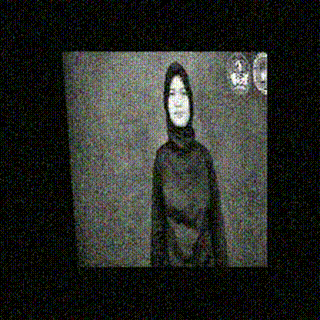

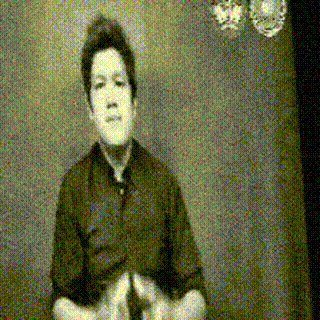

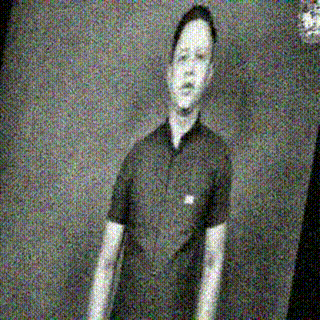

In [3]:
import os
import subprocess
from IPython.display import Image, display

def convert_video_to_gif(video_path, gif_path, start_time=0, duration=10, width=320):
    """ Convert a video file to a GIF using ffmpeg. """
    if not os.path.exists(video_path):
        print(f"Error: The video file does not exist at {video_path}")
        return

    command = [
        'ffmpeg',
        '-i', video_path,
        '-vf', f"fps=10,scale={width}:-1:flags=lanczos",  # Adjust frame rate and scale
        '-t', str(duration),
        '-ss', str(start_time),
        gif_path
    ]

    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def play_multiple_videos_as_gifs(video_paths, gif_paths, start_time=0, duration=10, width=320):
    """ Convert multiple videos to GIFs and display them in the notebook. """
    for i, video_path in enumerate(video_paths):
        gif_path = gif_paths[i]
        convert_video_to_gif(video_path, gif_path, start_time, duration, width)

        if os.path.exists(gif_path):
            display(Image(filename=gif_path))  # Display the GIF
        else:
            print(f"Error: GIF file not created for {video_path}.")

# Define the video paths and corresponding GIF paths
video_paths = [
    '/content/drive/MyDrive/New folder/Augmented_videos/Augmented_train_data/adik/1_normalized_augmented_1.mp4',
    '/content/drive/MyDrive/New folder/Augmented_videos/Augmented_train_data/besar/1_normalized_augmented_1.mp4',
    '/content/drive/MyDrive/New folder/Augmented_videos/Augmented_train_data/buka/1_normalized_augmented_1.mp4',

    ]

gif_paths = [
    '/content/1_normalized_augmented4_adik.gif',
    '/content/1_normalized_augmented4_besar.gif',
    '/content/1_normalized_augmented4_buka.gif'



]

# Convert and display videos as GIFs
play_multiple_videos_as_gifs(video_paths, gif_paths, start_time=0, duration=5, width=320)
